In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
bookings = pd.read_csv('/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/bookings_full.csv', parse_dates=['pickup_date','dropoff_date'])

In [53]:
bookings.head()

,booking_id,booking_date,customer_id,camper_id,pickup_date,rental_days,dropoff_date,pickup_location,dropoff_location,booking_channel,...,signup_date,country,model,type,year,location_id,service_due,day_of_week,is_weekend,holiday_flag
0,BK00000,2024-01-04,CUST00536,RV00972,2024-01-08,12,2024-01-20,LOC015,LOC063,Walk-in,...,2020-06-22,Svalbard & Jan Mayen Islands,Name,Truck Camper,2013,LOC068,No,Monday,False,0
1,BK00001,2023-01-20,CUST31935,RV00830,2023-02-26,2,2023-02-28,LOC008,LOC043,Online,...,2023-09-20,Congo,Include,Class A,2010,LOC013,No,Sunday,True,0
2,BK00002,2024-07-01,CUST02200,RV00411,2024-08-10,13,2024-08-23,LOC006,LOC001,Online,...,2022-04-06,Venezuela,Table,Class B,2014,LOC057,No,Saturday,True,0
3,BK00003,2023-06-28,CUST43422,RV00812,2023-08-30,12,2023-09-11,LOC069,LOC013,Online,...,2022-11-20,Iran,Today,Class C,2020,LOC010,No,Wednesday,False,0
4,BK00004,2022-08-08,CUST48470,RV00043,2022-10-15,5,2022-10-20,LOC085,LOC010,App,...,2022-05-17,Cook Islands,Forget,Pop-Up,2016,LOC039,No,Saturday,True,0


In [54]:
df = bookings
df.shape[0]

50000

In [55]:
# Drop extreme outliers
q_low = df['total_price'].quantile(0.01)
q_high = df['total_price'].quantile(0.99)
df = df[(df['total_price'] >= q_low) & (df['total_price'] <= q_high)]

In [56]:
df.shape[0]

49005

##### -------------------------------
##### 📊 EDA: Price Patterns
##### -------------------------------

In [57]:
fig = px.box(df, x='type', y='total_price',
             title='💰 Price Distribution by Camper Type')
fig.update_layout(xaxis_title='Camper Type',
                  yaxis_title='Total Price',
                  template='plotly_white')
fig.show()

In [58]:
# temporal features
df['month'] = df['pickup_date'].dt.month
df['dayofweek'] = df['pickup_date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['year'] = df['pickup_date'].dt.year

In [59]:
# Duration in days
df['duration'] = (pd.to_datetime(df['dropoff_date']) - pd.to_datetime(df['pickup_date'])).dt.days

In [60]:
# camper encoding
df = pd.get_dummies(df, columns=['type','country'], drop_first=True)

##### -------------------------------
##### 🧠 Modeling: Predicting Price
##### -------------------------------

In [61]:

features = ['duration', 'month', 'dayofweek', 'is_weekend', 'year', 'base_price'] + \
            [col for col in df.columns if col.startswith('type_') or col.startswith('country_')]

In [62]:
X = df[features]
y = df['total_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)

In [64]:
# ElasticNet
en = ElasticNetCV(cv=5)
en.fit(X_train, y_train)
preds_en = en.predict(X_test)

In [65]:
# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)
preds_xgb = xgb.predict(X_test)

##### -------------------------------
##### 📈 Evaluate Models
##### -------------------------------

In [66]:
def evaluate(name, y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")

In [67]:
evaluate("Linear Regression", y_test, preds_lr)
evaluate("ElasticNet", y_test, preds_en)
evaluate("XGBoost", y_test, preds_xgb)

Linear Regression -> RMSE: 152.07, MAE: 115.09
ElasticNet -> RMSE: 275.78, MAE: 202.59
XGBoost -> RMSE: 3.38, MAE: 2.48


##### -------------------------------
##### 📉 Visualize Predictions
##### -------------------------------

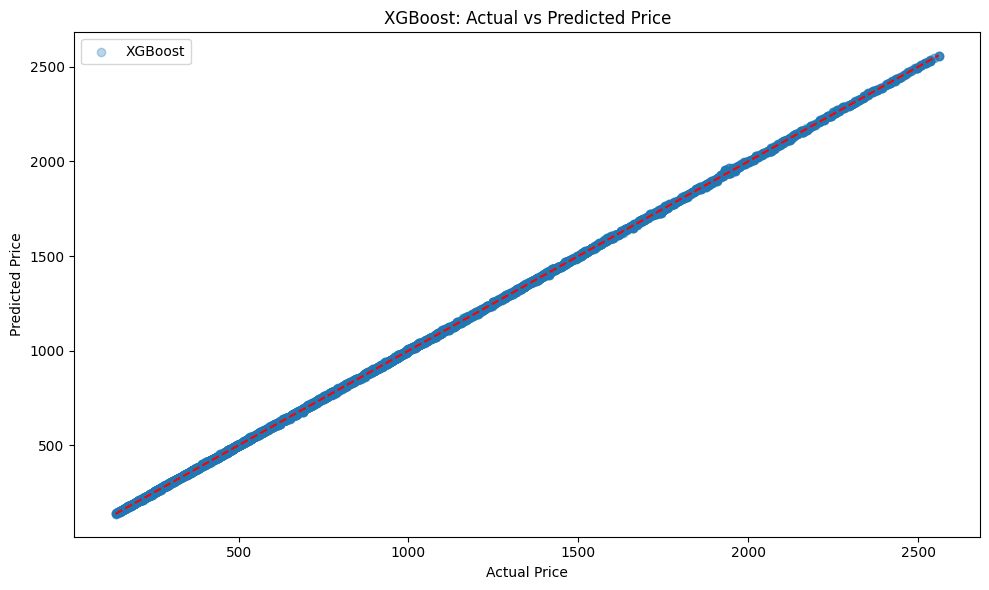

In [68]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, preds_xgb, alpha=0.3, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted Price')
plt.legend()
plt.tight_layout()
plt.show()

##### -------------------------------
##### 💡 Price Strategy Simulation
##### -------------------------------

In [69]:
df['predicted_price'] = xgb.predict(df[features])
df['price_diff'] = df['predicted_price'] - df['total_price']
df['price_recommendation'] = np.where(df['price_diff'] > 0, "Raise", "Lower")


In [70]:
recommendation_summary = df['price_recommendation'].value_counts(normalize=True) * 100
print('\n 💹Price Adjustment Recommendation (%):')
print(recommendation_summary.round(2))



 💹Price Adjustment Recommendation (%):
price_recommendation
Lower    50.71
Raise    49.29
Name: proportion, dtype: float64


In [71]:
df[['booking_id', 'total_price', 'predicted_price','price_diff', 'price_recommendation']].to_csv("/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/price_optimization_recommendations.csv", index=False)
print(f"✅ price optimization data saved")

✅ price optimization data saved
